In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/home/dgroppe/TFLOW_VE3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print("python:{}, keras:{}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

python:3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0], keras:2.1.6, tensorflow: 1.8.0


In [3]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

in_out_neurons = 2  
hidden_neurons = 300

model = Sequential()
model.add(LSTM(hidden_neurons, return_sequences=False,
               input_shape=(None, in_out_neurons)))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")  

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               363600    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 602       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 364,202
Trainable params: 364,202
Non-trainable params: 0
_________________________________________________________________


In [5]:
import pandas as pd  
from random import random

flow = (list(range(1,10,1)) + list(range(10,1,-1)))*1000  
pdata = pd.DataFrame({"a":flow, "b":flow})  
pdata.b = pdata.b.shift(9)  
data = pdata.iloc[10:] * random()  # some noise  

In [9]:
data=data.values
print(data.shape)
print(type(data))

(17990, 2)
<class 'numpy.ndarray'>


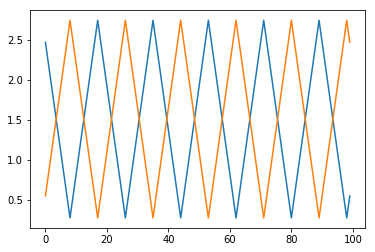

In [11]:
plt.figure(1)
plt.clf()
plt.plot(data[:100,:])

In [67]:
import numpy as np

def _load_data(data, n_prev = 100):  
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data[i:i+n_prev])
        docY.append(data[i+n_prev])
        #docX.append(data.iloc[i:i+n_prev].as_matrix())
        #docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def rand_clips(data, n_prev = 100, n_clips=1000):  
    X=np.zeros((n_clips,n_prev,2))
    Y=np.zeros((n_clips,2))
    n_tpt=data.shape[0]
    for i in range(n_clips):
        start_id=np.random.randint(0,n_tpt-1-n_prev)
        X[i,0:n_prev,0:2]=data[start_id:start_id+n_prev,:]
        Y[i,0:2]=data[start_id+n_prev:start_id+n_prev+1,:]
    return X, Y

def train_test_split(df, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    X_train, y_train = rand_clips(df[0:ntrn,:])
    #X_test, y_test = rand_clips(df[ntrn:,:])
    #X_train, y_train = _load_data(df[0:ntrn,:])
    X_test, y_test = _load_data(df[ntrn:,:])

    return (X_train, y_train), (X_test, y_test)

In [38]:
data.shape

(17990, 2)

In [68]:
# Extract data from data frame
(X_train, y_train), (X_test, y_test) = train_test_split(data)  # retrieve data
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test.shape[0]+y_train.shape[0])

(17990, 2)
(1000, 100, 2)
(1000, 2)
(1699, 100, 2)
(1699, 2)
2699


(17990, 2)
(16091, 100, 2)
(16091, 2)
(1699, 100, 2)
(1699, 2)
17790


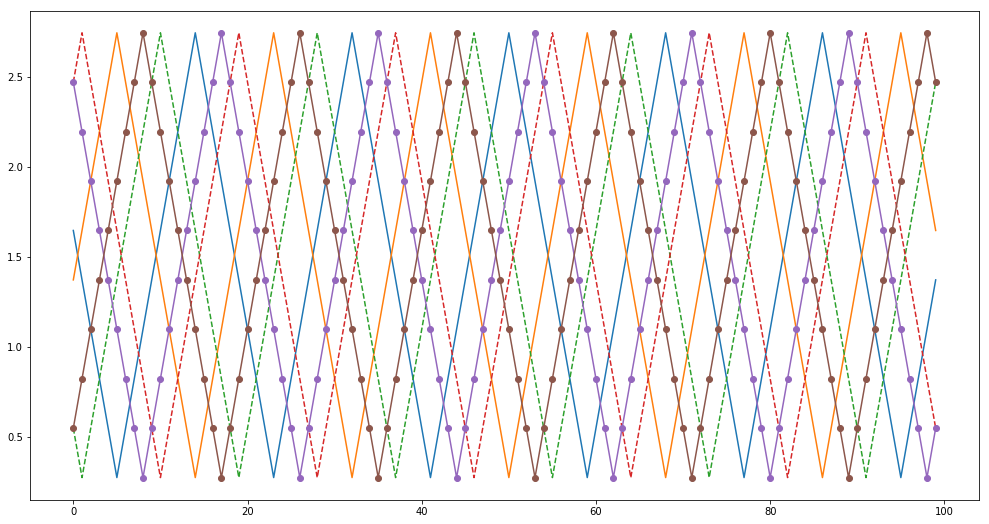

In [61]:
plt.figure(1)
plt.clf()
plt.plot(np.squeeze(X_train[0,:,:]))
plt.plot(np.squeeze(X_train[1,:,:]),'--')
plt.plot(np.squeeze(X_train[2,:,:]),'-o')

In [62]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=450, epochs=10, validation_split=0.05)  

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0181 - val_loss: 0.0073
Epoch 2/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0100 - val_loss: 0.0111
Epoch 3/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0117 - val_loss: 0.0062
Epoch 4/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0067 - val_loss: 0.0084
Epoch 5/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0091 - val_loss: 0.0100
Epoch 6/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 7/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0091 - val_loss: 0.0035
Epoch 8/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0067 - val_loss: 0.0250
Epoch 9/10
950/950 [==============================] - 2s 2ms/step - loss: 0.0172 - val_loss: 0.0101
Epoch 10/10
950/950 [==============================] - 

In [69]:
predicted = model.predict(X_test)  
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
print(X_test.shape)
print(predicted.shape)
print('Test RMSE={}'.format(rmse))

(1699, 100, 2)
(1699, 2)
Test RMSE=[0.10473419 0.09490266]


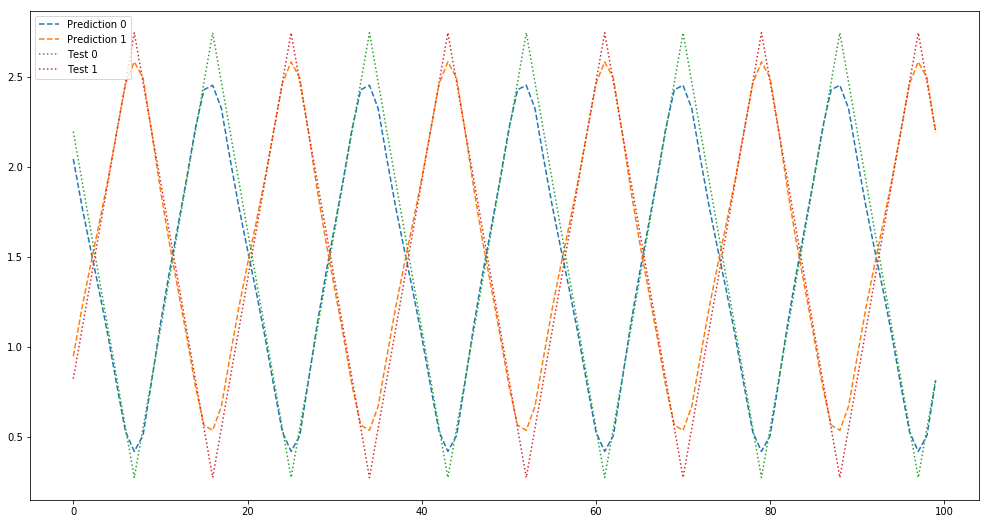

In [70]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (17, 9)
plt.plot(predicted[:100][:,0],"--")
plt.plot(predicted[:100][:,1],"--")
plt.plot(y_test[:100][:,0],":")
plt.plot(y_test[:100][:,1],":")
plt.legend(["Prediction 0", "Prediction 1", "Test 0", "Test 1"])

In [28]:
# Save Model
model.save('tri_wave_keras.h5')

In [30]:
# Load Model and Generate Predictions
from keras.models import load_model
model2=load_model('tri_wave_keras.h5')
predicted2 = model2.predict(X_test)  

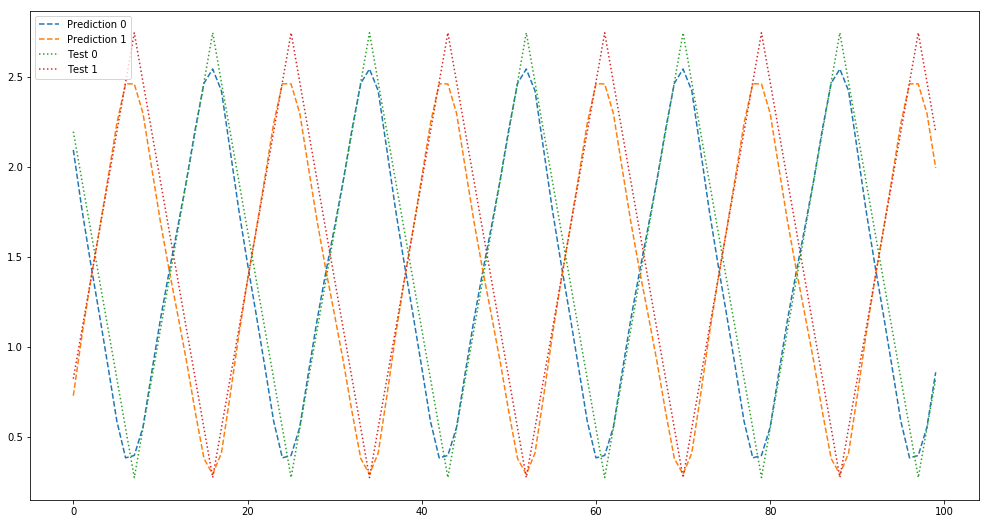

In [31]:
plt.rcParams["figure.figsize"] = (17, 9)
plt.plot(predicted2[:100][:,0],"--")
plt.plot(predicted2[:100][:,1],"--")
plt.plot(y_test[:100][:,0],":")
plt.plot(y_test[:100][:,1],":")
plt.legend(["Prediction 0", "Prediction 1", "Test 0", "Test 1"])

In [33]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)